In [2]:
import json
import os
import pickle
import sys
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import seaborn as sns

from itertools import product
from itertools import combinations_with_replacement as cwr

from scipy.ndimage import gaussian_filter1d as smooth

nmb_rep = 100

outPath = os.path.join(dirs['out']['rsa'])
os.makedirs(outPath, exist_ok=True)

In [3]:
monkey = "both"
selectivity = "fast"

with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")
info = info[~noneIndex & sIndex]
info.con = info.con.astype('category')
info.con = info.con.cat.reorder_categories(['human body', 'human face', 'monkey body', 'monkey face', 'natural', 'artificial'])

argsort = np.argsort(
    info.con.astype('category').cat.set_categories(
        ['human face', 'monkey face', 'human body', 'monkey body', 'artificial', 'natural'], 
        ordered=True
    )
)

info = info.iloc[argsort]
index = info.index
info = info.reset_index(drop=True)

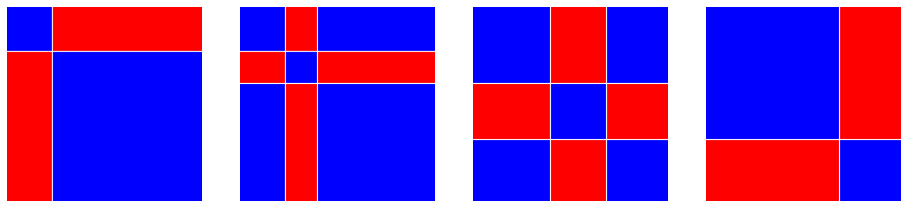

In [4]:
groundTruth = {}

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for ax, category in zip(axs, ['face', 'body', 'artificial', 'natural']):
    mat = np.nan * np.ones([len(info), len(info)])

    ind = (info.cat==category).to_numpy()
    mat[np.ix_(ind, ind)]   = 0
    mat[np.ix_(~ind, ~ind)] = 0
    mat[np.ix_(ind, ~ind)]  = 1
    mat[np.ix_(~ind, ind)]  = 1

    groundTruth[category] = mat

    ax.imshow(mat, cmap='bwr')
    ax.axis('off')

In [5]:
with open('ground-truth.pickle', 'wb') as f:
    pickle.dump(groundTruth, f, protocol=pickle.HIGHEST_PROTOCOL)